In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd

# Cuidado al usar Prophet. De-registra los convertores de pandas para matplotlib, ocasionando bugs.
from fbprophet import Prophet 

C:\Users\ariel\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\ariel\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
pd.plotting.register_matplotlib_converters() # Volvemos a registrar los convertores.
plt.rcParams['figure.figsize'] = [16, 4]

### Preparación de datos

In [7]:
data_hourly = pd.read_csv("./data/pronóstico_horario_abril_sept.csv", parse_dates=["fecha"], index_col="fecha")
data_hourly.head(10)

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion,faltante
fecha,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,E,14.8,6.0,0.0,28.9,18.7,Nuboso,False
2019-04-01 01:00:00,19.2,93.0,1016.7,E,9.4,4.0,0.0,20.1,12.5,Nubes dispersas,False
2019-04-01 02:00:00,18.5,95.0,1016.7,E,3.6,0.0,0.0,20.1,12.5,Despejado,False
2019-04-01 03:00:00,15.2,96.0,1016.7,S,5.4,0.0,0.0,20.1,12.5,"Despejado, neblina",False
2019-04-01 04:00:00,16.2,95.0,1016.3,E,7.6,4.0,0.0,20.1,12.5,"Nubes dispersas, neblina",False
2019-04-01 05:00:00,16.0,96.0,1016.6,-,0.0,4.0,0.0,20.1,12.5,"Nubes dispersas, neblina",False
2019-04-01 06:00:00,15.6,96.0,1015.8,-,0.0,5.0,0.0,20.1,12.5,"Nuboso, neblina",False
2019-04-01 07:00:00,15.2,96.0,1015.2,E,5.4,7.0,0.0,20.1,12.5,"Nuboso, neblina",False
2019-04-01 08:00:00,15.0,95.0,1014.9,SE,5.4,6.0,0.0,20.1,12.5,"Nuboso, neblina",False


In [8]:
data_hourly.tail()

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion,faltante
fecha,,,,,,,,,,,
2019-09-04 15:00:00,8.6,42.0,1031.0,S,33.5,3.0,0.0,NaN,NaN,Nubes dispersas,False
2019-09-04 16:00:00,8.6,39.0,1031.0,S,25.9,6.0,0.0,NaN,NaN,Nuboso,False
2019-09-04 17:00:00,8.7,33.0,1030.9,S,29.5,8.0,0.0,NaN,NaN,"Cubierto, precipitación a la vista",False
2019-09-04 18:00:00,7.7,41.0,1030.9,S,27.7,7.0,0.0,NaN,NaN,Nuboso,False
2019-09-04 19:00:00,8.2,46.0,1030.8,S,24.1,7.0,0.0,NaN,NaN,Nuboso,False


In [10]:
data_hourly.isna().sum()

temp         77
hum          83
presion      78
dir          73
vel          73
nub          73
prec         73
t_max        80
t_min        80
situacion    73
faltante      0
dtype: int64

In [11]:
potencia = pd.read_csv("./data/potencia.csv", parse_dates=["fecha"], index_col="fecha")

In [16]:
potencia.head()

,potencia
fecha,
2019-05-30 12:45:00,975
2019-05-30 12:46:00,1003
2019-05-30 12:47:00,1007
2019-05-30 12:48:00,989
2019-05-30 12:49:00,800


In [17]:
potencia = potencia.rename(columns={"potencia":"pot"})

In [18]:
potencia_h = potencia.resample("H").mean()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


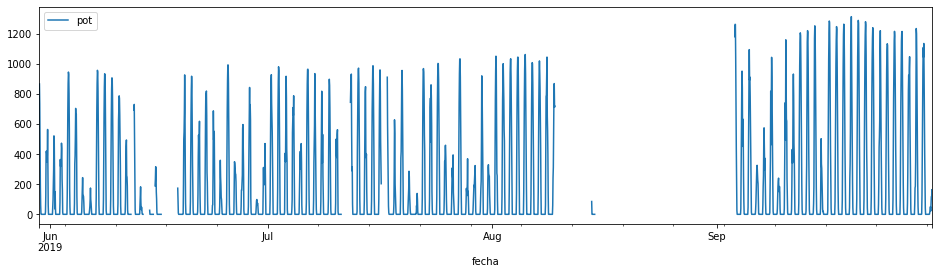

In [19]:
potencia_h.plot()

In [20]:
train = potencia_h.loc["2019-07-01":"2019-07-31"].copy()
test = potencia_h.loc["2019-08-01":"2019-08-07"].copy()

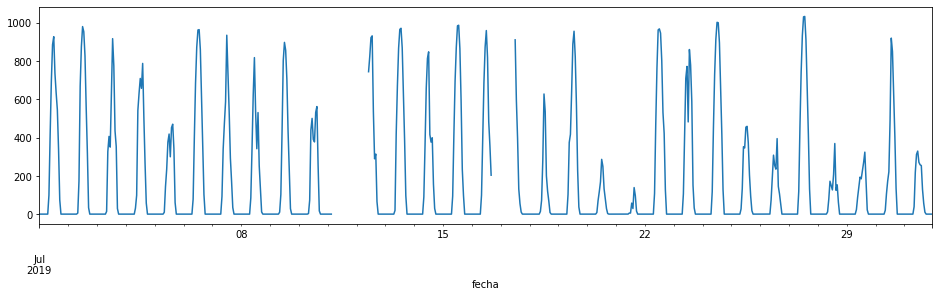

In [21]:
train.pot.plot()

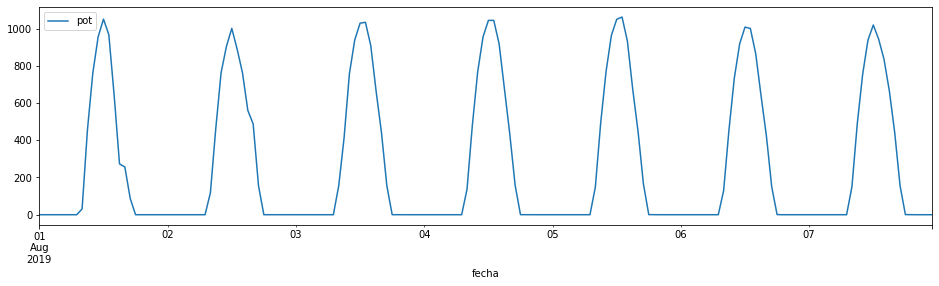

In [22]:
test.plot()

In [27]:
train.loc[:,"dia"] = train.index.day
train.loc[:,"hora"] = train.index.hour

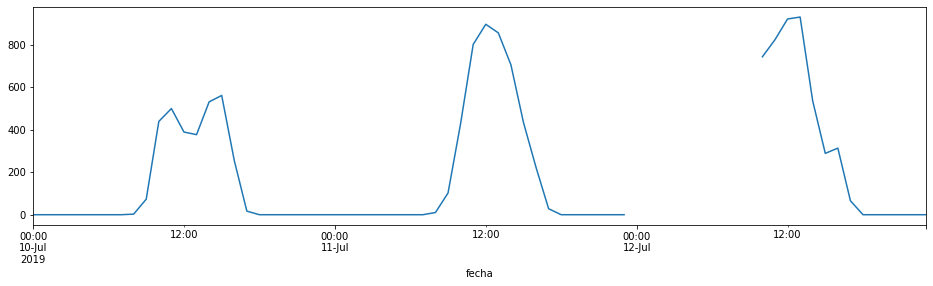

In [28]:
train.loc[train.dia.isin([10,11,12]), "pot"].plot()

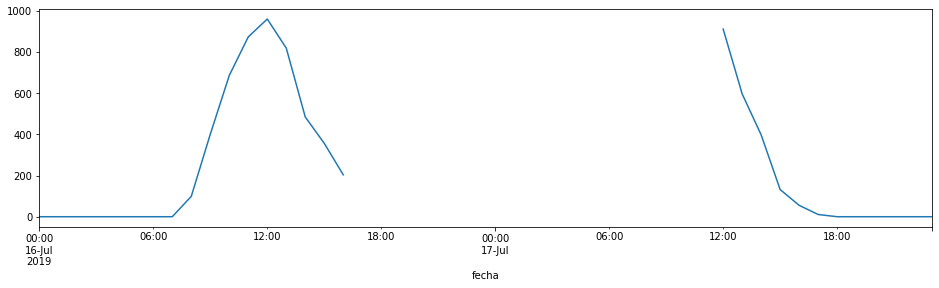

In [29]:
train.loc[train.dia.isin([16,17]), "pot"].plot()

In [30]:
values = train.loc[train.dia == 9, "pot"].to_numpy()
train.loc[train.dia == 11, "pot"] = values

In [31]:
train.loc[(train.dia == 12) & (train.hora.isin(range(0,8))), "pot"] = 0
train.loc[(train.dia == 17) & (train.hora.isin(range(0,8))), "pot"] = 0
train.loc[(train.dia == 16) & (train.hora.isin(range(18,24))), "pot"] = 0

In [32]:
train.loc[:, "pot"] = train.loc[:,"pot"].interpolate(method="spline", order=2)

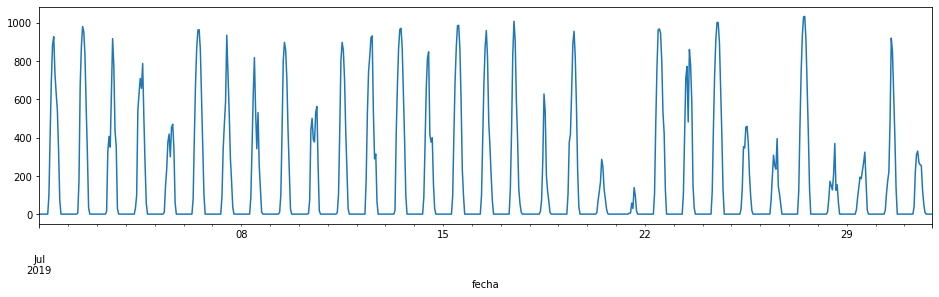

In [33]:
train.pot.plot()

In [34]:
train = train.drop(columns=["dia", "hora"])

In [35]:
exog_train = data_hourly.loc["2019-07-01":"2019-07-31", ["temp", "hum", "presion", "vel", "nub"]].copy()
exog_test = data_hourly.loc["2019-08-01":"2019-08-07", ["temp", "hum", "presion", "vel", "nub"]].copy()

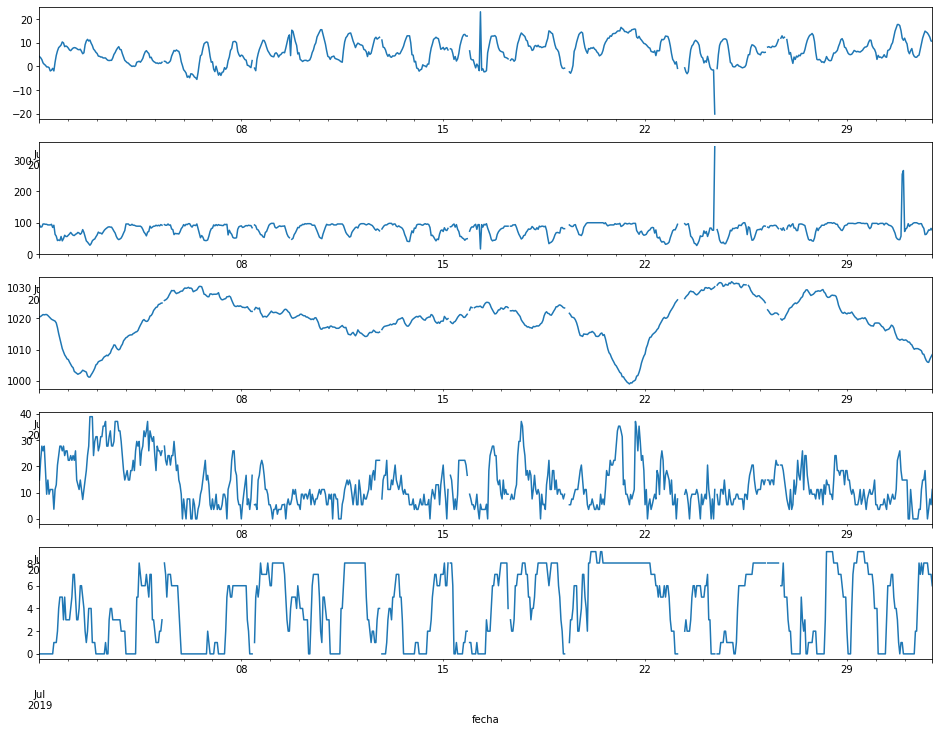

In [36]:
f, ax = plt.subplots(len(exog_train.columns), 1, figsize=(16,12))
for k,col in enumerate(exog_train.columns):
    exog_train[col].plot(ax=ax[k])

In [37]:
exog_train["dia"] = exog_train.index.day
exog_train["hora"] = exog_train.index.hour

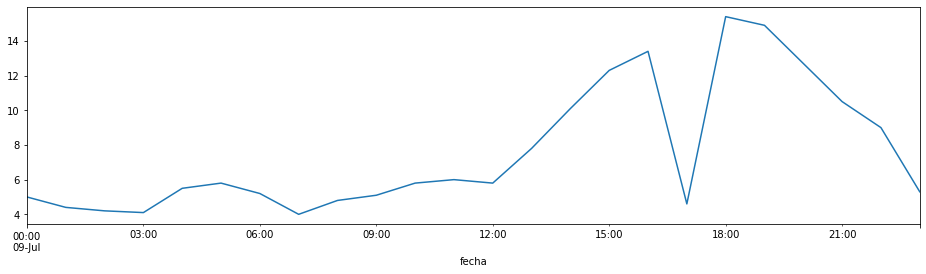

In [38]:
exog_train.loc[exog_train.dia == 9, "temp"].plot()

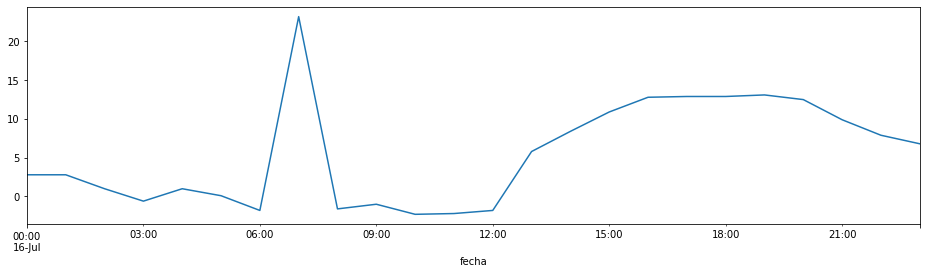

In [39]:
exog_train.loc[exog_train.dia == 16, "temp"].plot()

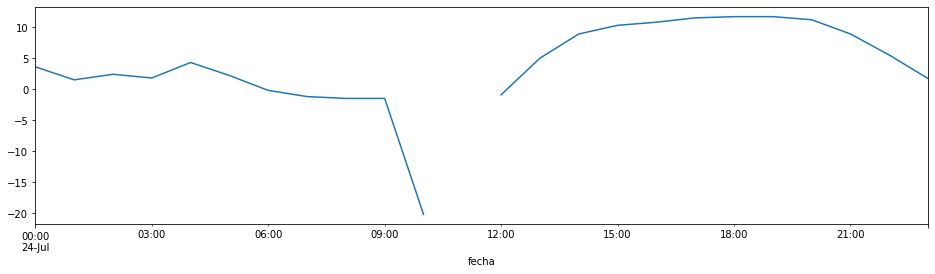

In [40]:
exog_train.loc[exog_train.dia == 24, "temp"].plot()

In [41]:
exog_train.loc[(exog_train.dia == 9) & (exog_train.hora == 17), "temp"] = np.nan
exog_train.loc[(exog_train.dia == 16) & (exog_train.hora == 7), "temp"] = np.nan
exog_train.loc[(exog_train.dia == 24) & (exog_train.hora == 10), "temp"] = np.nan

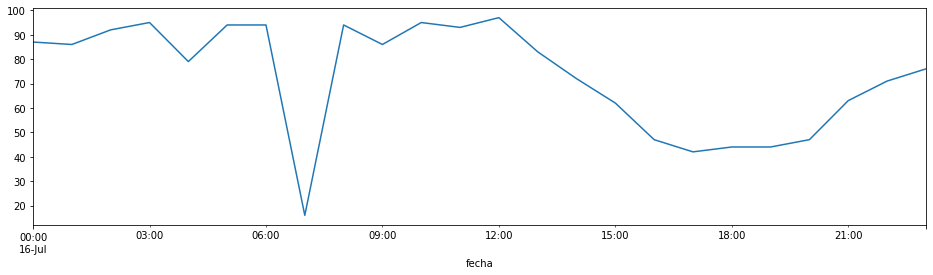

In [42]:
exog_train.loc[exog_train.dia == 16, "hum"].plot()

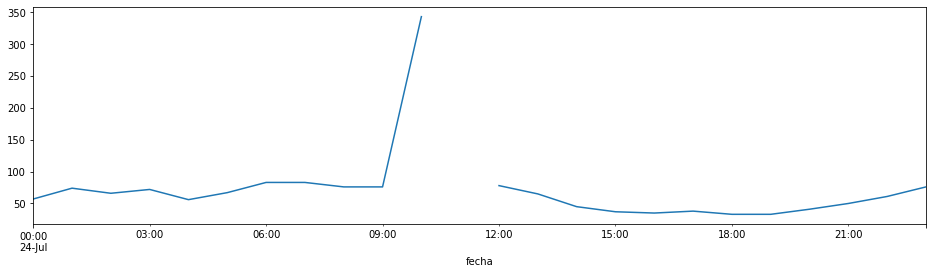

In [43]:
exog_train.loc[exog_train.dia == 24, "hum"].plot()

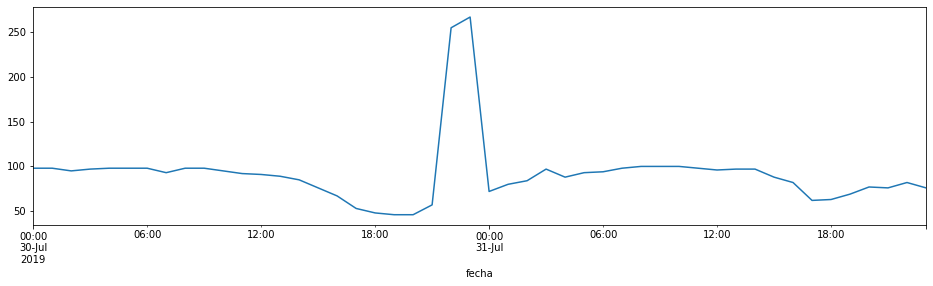

In [44]:
exog_train.loc[exog_train.dia.isin([30,31]), "hum"].plot()

In [45]:
exog_train.loc[(exog_train.dia == 16) & (exog_train.hora == 7), "hum"] = np.nan
exog_train.loc[(exog_train.dia == 24) & (exog_train.hora == 10), "hum"] = np.nan
exog_train.loc[(exog_train.dia == 30) & (exog_train.hora == 22), "hum"] = np.nan
exog_train.loc[(exog_train.dia == 30) & (exog_train.hora == 23), "hum"] = np.nan

In [46]:
values = exog_train.loc[:, ["temp", "hum", "presion", "vel"]].interpolate(method="linear")
exog_train.loc[:, ["temp", "hum", "presion", "vel"]] = values
exog_train.nub = exog_train.nub.fillna(method="ffill")

In [47]:
exog_train = exog_train.drop(columns=["dia", "hora"])

In [48]:
exog_train.isna().sum()

temp       0
hum        0
presion    0
vel        0
nub        0
dtype: int64

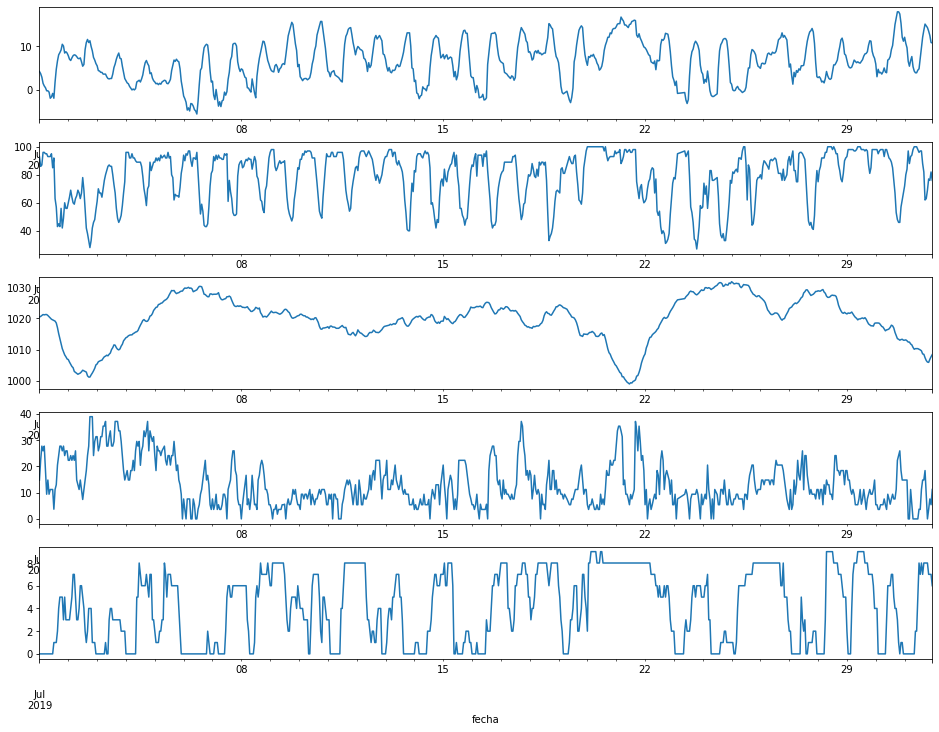

In [49]:
cols = exog_train.columns
f, ax = plt.subplots(len(cols), 1, figsize=(16,12))
for k,col in enumerate(cols):
    exog_train[col].plot(ax=ax[k])

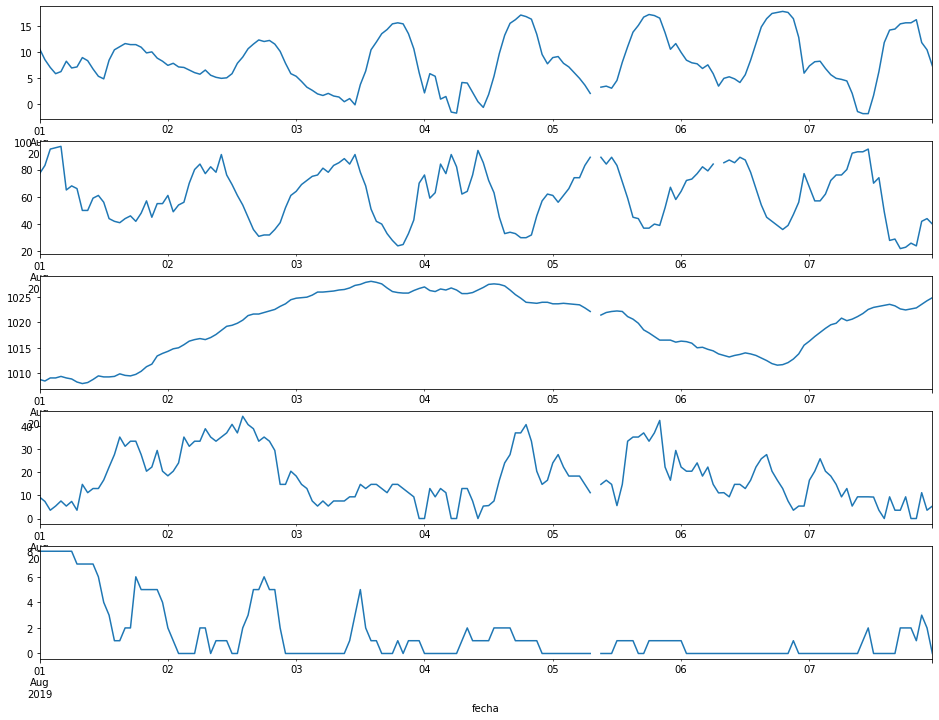

In [50]:
cols = exog_test.columns
f, ax = plt.subplots(len(cols), 1, figsize=(16,12))
for k,col in enumerate(cols):
    exog_test[col].plot(ax=ax[k])

In [51]:
values = exog_test.loc[:, ["temp", "hum", "presion", "vel"]].interpolate(method="linear")
exog_test.loc[:, ["temp", "hum", "presion", "vel"]] = values
exog_test.nub = exog_test.nub.fillna(method="ffill")

In [52]:
exog_test.isna().sum()

temp       0
hum        0
presion    0
vel        0
nub        0
dtype: int64

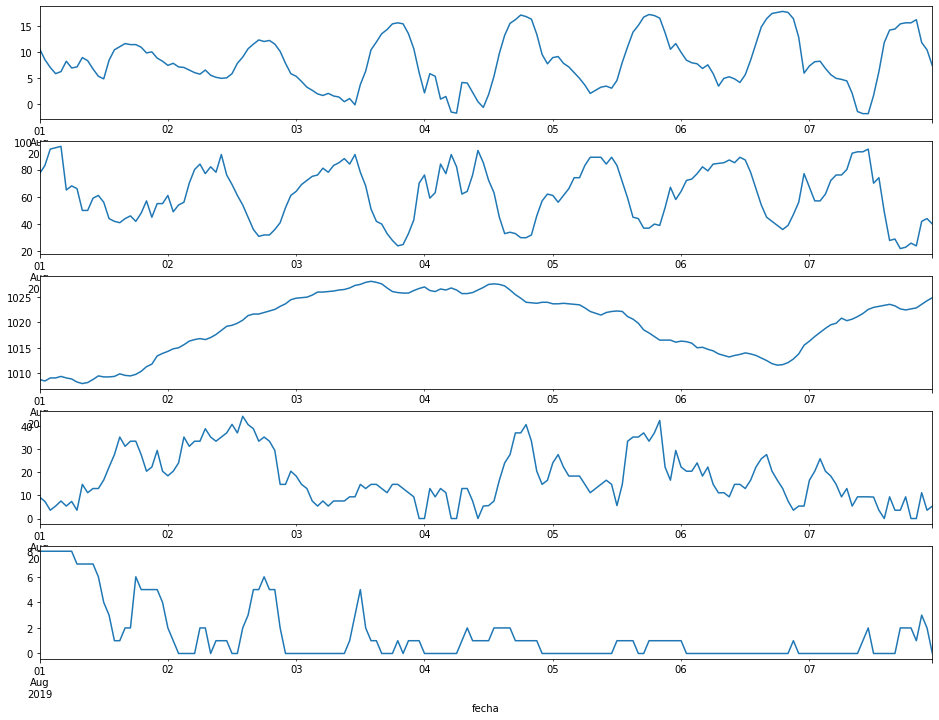

In [53]:
cols = exog_test.columns
f, ax = plt.subplots(len(cols), 1, figsize=(16,12))
for k,col in enumerate(cols):
    exog_test[col].plot(ax=ax[k])

## ARIMA

In [162]:
fit_autoarima = pmd.auto_arima(train, exogenous=exog_train, seasonal=True, m=24, d=0, D=1, trace=True, suppress_warnings=True)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 24); AIC=8311.371, BIC=8370.902, Fit time=62.723 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 24); AIC=9552.826, BIC=9584.880, Fit time=0.609 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 24); AIC=8571.946, BIC=8613.159, Fit time=25.155 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 24); AIC=8612.019, BIC=8653.233, Fit time=26.263 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 1, 24); AIC=8308.775, BIC=8363.726, Fit time=34.485 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 0, 24); AIC=8723.239, BIC=8773.611, Fit time=8.001 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 2, 24); AIC=8310.752, BIC=8370.282, Fit time=78.716 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 2, 24); AIC=8322.647, BIC=8386.756, Fit time=90.380 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 1, 1, 24); AIC=8311.629, BIC=8362.001, Fit time=35.363 seconds
Fit ARIMA: order=(3, 

In [170]:
forecast = fit_autoarima.predict(n_periods=24*7, exogenous=exog_test)
forecast = pd.Series(forecast, index=test.index)

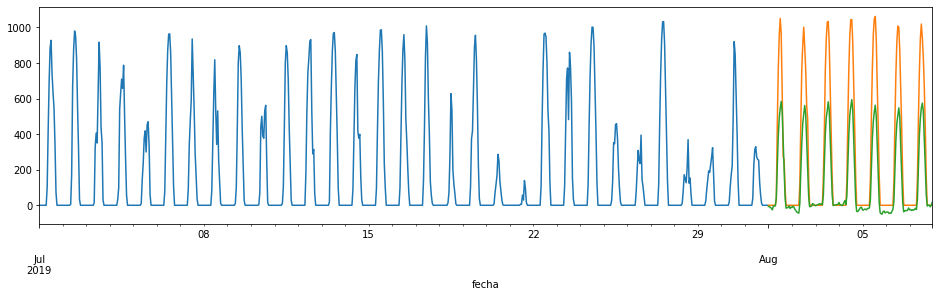

In [172]:
train.pot.plot()
test.pot.plot()
forecast.plot()

In [173]:
in_sample = fit_autoarima.predict_in_sample(exogenous=exog_train, start=0, end=743)
in_sample = pd.Series(in_sample, index=train.index)

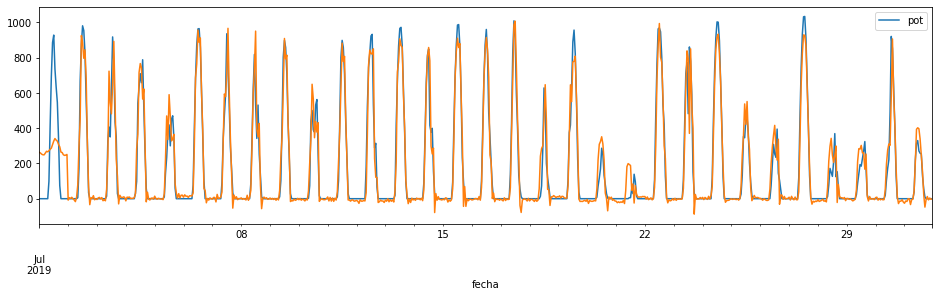

In [174]:
train.plot()
in_sample.plot()

## Prophet

In [55]:
train_data = train.join(exog_train)
train_data = train_data.reset_index().rename(columns={"fecha":"ds", "pot":"y"})
train_data.head()

,ds,y,temp,hum,presion,vel,nub
0,2019-07-01 00:00:00,0.0,4.2,93.0,1020.4,14.8,0.0
1,2019-07-01 01:00:00,0.0,3.7,86.0,1020.6,22.3,0.0
2,2019-07-01 02:00:00,0.0,2.9,87.0,1020.9,27.7,0.0
3,2019-07-01 03:00:00,0.0,1.5,96.0,1021.2,25.9,0.0
4,2019-07-01 04:00:00,0.0,0.9,96.0,1021.1,27.7,0.0


In [56]:
test_data = test.join(exog_test)
test_data = test_data.reset_index().rename(columns={"fecha":"ds", "pot":"y"})
test_data.tail()

,ds,y,temp,hum,presion,vel,nub
163,2019-08-07 19:00:00,0.0,15.6,26.0,1022.6,0.0,2.0
164,2019-08-07 20:00:00,0.0,16.2,24.0,1022.8,0.0,1.0
165,2019-08-07 21:00:00,0.0,11.8,42.0,1023.5,11.2,3.0
166,2019-08-07 22:00:00,0.0,10.4,44.0,1024.2,3.6,2.0
167,2019-08-07 23:00:00,0.0,7.3,40.0,1024.8,5.4,0.0


In [57]:
model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=False, yearly_seasonality=False, 
                        seasonality_mode="additive")

In [58]:
model_prophet.add_regressor("temp")
model_prophet.add_regressor("hum")
model_prophet.add_regressor("presion")
model_prophet.add_regressor("vel")
model_prophet.add_regressor("nub")

In [59]:
model_prophet.fit(train_data)

In [60]:
future = model_prophet.make_future_dataframe(24*7, freq="H", include_history=True)

In [61]:
exogs = pd.concat([train_data, test_data])
exogs = exogs.drop(columns="y")
exogs.head()

,ds,temp,hum,presion,vel,nub
0,2019-07-01 00:00:00,4.2,93.0,1020.4,14.8,0.0
1,2019-07-01 01:00:00,3.7,86.0,1020.6,22.3,0.0
2,2019-07-01 02:00:00,2.9,87.0,1020.9,27.7,0.0
3,2019-07-01 03:00:00,1.5,96.0,1021.2,25.9,0.0
4,2019-07-01 04:00:00,0.9,96.0,1021.1,27.7,0.0


In [62]:
future = pd.merge(future, exogs, on="ds")

In [63]:
forecast = model_prophet.predict(future)

In [64]:
yhat = forecast[["ds", "yhat"]]
yhat.head()

,ds,yhat
0,2019-07-01 00:00:00,21.621995
1,2019-07-01 01:00:00,37.275974
2,2019-07-01 02:00:00,49.653092
3,2019-07-01 03:00:00,46.740943
4,2019-07-01 04:00:00,49.597134


In [65]:
yhat = yhat.set_index("ds")

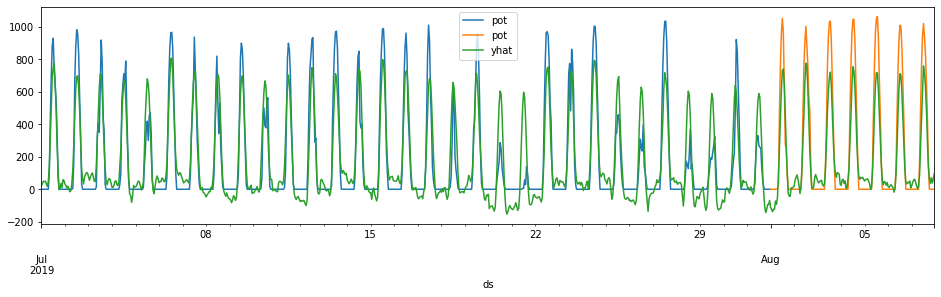

In [66]:
ax = train.plot()
test.plot(ax=ax)
yhat.plot(ax=ax)

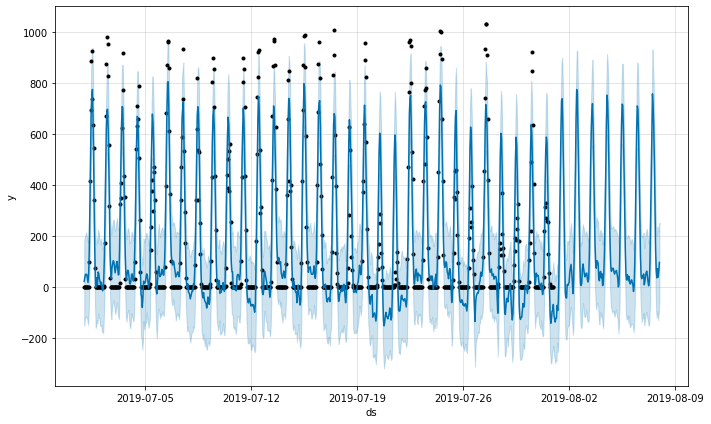

In [67]:
model_prophet.plot(forecast);

## Rolling forecast con Prophet

In [406]:
train_data = train.join(exog_train)
train_data = train_data.reset_index().rename(columns={"fecha":"ds", "pot":"y"})
train_data.head()

,ds,y,temp,hum,presion,vel,nub
0,2019-07-01 00:00:00,0.0,4.2,93.0,1020.4,14.8,0.0
1,2019-07-01 01:00:00,0.0,3.7,86.0,1020.6,22.3,0.0
2,2019-07-01 02:00:00,0.0,2.9,87.0,1020.9,27.7,0.0
3,2019-07-01 03:00:00,0.0,1.5,96.0,1021.2,25.9,0.0
4,2019-07-01 04:00:00,0.0,0.9,96.0,1021.1,27.7,0.0


In [407]:
test_data = test.join(exog_test)
test_data = test_data.reset_index().rename(columns={"fecha":"ds", "pot":"y"})
test_data.tail()

,ds,y,temp,hum,presion,vel,nub
163,2019-08-07 19:00:00,0.0,15.6,26.0,1022.6,0.0,2.0
164,2019-08-07 20:00:00,0.0,16.2,24.0,1022.8,0.0,1.0
165,2019-08-07 21:00:00,0.0,11.8,42.0,1023.5,11.2,3.0
166,2019-08-07 22:00:00,0.0,10.4,44.0,1024.2,3.6,2.0
167,2019-08-07 23:00:00,0.0,7.3,40.0,1024.8,5.4,0.0


In [527]:
model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=False, yearly_seasonality=False)

In [528]:
model_prophet.fit(train_data)

In [529]:
#future_1h = model_prophet.make_future_dataframe(1, freq="H", include_history=False)
future_12h = model_prophet.make_future_dataframe(12, freq="H", include_history=False)

In [532]:
exogs_future = test_data.drop(columns="y")
exogs_future.head()

,ds,temp,hum,presion,vel,nub
0,2019-08-01 00:00:00,10.6,77.0,1008.8,9.3,8.0
1,2019-08-01 01:00:00,8.5,83.0,1008.5,7.4,8.0
2,2019-08-01 02:00:00,7.0,95.0,1009.1,3.6,8.0
3,2019-08-01 03:00:00,5.8,96.0,1009.1,5.4,8.0
4,2019-08-01 04:00:00,6.2,97.0,1009.4,7.6,8.0


In [533]:
future = pd.merge(future_12h, exogs_future, on="ds")
future

,ds,temp,hum,presion,vel,nub
0,2019-08-01 00:00:00,10.6,77.0,1008.8,9.3,8.0
1,2019-08-01 01:00:00,8.5,83.0,1008.5,7.4,8.0
2,2019-08-01 02:00:00,7.0,95.0,1009.1,3.6,8.0
3,2019-08-01 03:00:00,5.8,96.0,1009.1,5.4,8.0
4,2019-08-01 04:00:00,6.2,97.0,1009.4,7.6,8.0
5,2019-08-01 05:00:00,8.2,65.0,1009.1,5.4,8.0
6,2019-08-01 06:00:00,6.9,68.0,1008.9,7.4,8.0
7,2019-08-01 07:00:00,7.1,66.0,1008.3,3.6,7.0
8,2019-08-01 08:00:00,8.9,50.0,1008.0,14.8,7.0
9,2019-08-01 09:00:00,8.3,50.0,1008.2,11.2,7.0


In [534]:
forecast_12h = model_prophet.predict(future_12h)

In [537]:
forecast = pd.DataFrame()

In [539]:
pd.concat([forecast, forecast_12h])

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-08-01 00:00:00,118.892376,-242.136815,116.404857,118.892376,118.892376,-175.634030,-175.634030,-175.634030,-175.634030,-175.634030,-175.634030,0.0,0.0,0.0,-56.741654
1,2019-08-01 01:00:00,118.747641,-249.584632,118.719563,118.747641,118.747641,-177.825432,-177.825432,-177.825432,-177.825432,-177.825432,-177.825432,0.0,0.0,0.0,-59.077791
2,2019-08-01 02:00:00,118.602906,-224.622778,122.598277,118.602906,118.602906,-167.244241,-167.244241,-167.244241,-167.244241,-167.244241,-167.244241,0.0,0.0,0.0,-48.641334
3,2019-08-01 03:00:00,118.458171,-220.912698,138.914391,118.458171,118.458171,-155.340500,-155.340500,-155.340500,-155.340500,-155.340500,-155.340500,0.0,0.0,0.0,-36.882328
4,2019-08-01 04:00:00,118.313436,-219.715461,134.144579,118.313436,118.313436,-157.380143,-157.380143,-157.380143,-157.380143,-157.380143,-157.380143,0.0,0.0,0.0,-39.066707
5,2019-08-01 05:00:00,118.168701,-239.542157,115.517573,118.168701,118.168701,-175.728590,-175.728590,-175.728590,-175.728590,-175.728590,-175.728590,0.0,0.0,0.0,-57.559889
6,2019-08-01 06:00:00,118.023966,-244.557946,91.187402,118.023954,118.024729,-190.240409,-190.240409,-190.240409,-190.240409,-190.240409,-190.240409,0.0,0.0,0.0,-72.216442
7,2019-08-01 07:00:00,117.879231,-220.689140,134.232921,117.878038,117.881366,-165.612605,-165.612605,-165.612605,-165.612605,-165.612605,-165.612605,0.0,0.0,0.0,-47.733374
8,2019-08-01 08:00:00,117.734496,-126.508132,218.753521,117.731713,117.737788,-73.185825,-73.185825,-73.185825,-73.185825,-73.185825,-73.185825,0.0,0.0,0.0,44.548672
9,2019-08-01 09:00:00,117.589761,38.991062,380.737017,117.585032,117.595245,86.868194,86.868194,86.868194,86.868194,86.868194,86.868194,0.0,0.0,0.0,204.457956


In [574]:
forecasts = []
data = train_data.copy()
future_data = test_data.copy()
exogs_future = test_data.drop(columns="y")
for k in range(1, 24*5):
    model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=False, yearly_seasonality=False)
    model_prophet.fit(data)
    future_12h = model_prophet.make_future_dataframe(1, freq="H", include_history=False)
    future_12h = pd.merge(future_12h, exogs_future, on="ds")
    forecast_12h = model_prophet.predict(future_12h)
    forecasts.append(forecast_12h)
    data = pd.concat([data, future_data.iloc[1*(k-1):1*k]])

In [575]:
all_forecasts = pd.concat(forecasts)

In [576]:
yhat = all_forecasts[["ds", "yhat"]]

In [577]:
yhat = yhat.set_index("ds")

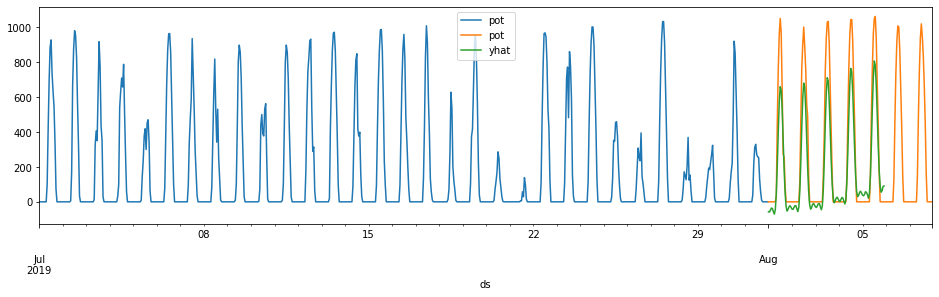

In [578]:
ax = train.plot()
ax = test.plot(ax=ax)
yhat.plot(ax=ax)